In [1]:
# --- STEP 0: ENVIRONMENT SETUP ---
import sys
# Install if missing (should be cached from previous steps)
%pip install "numpy<2.0" pandas fastf1 matplotlib scikit-learn scipy joblib --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# --- STEP 1: IMPORT LIBRARIES ---
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
# --- STEP 2: CONFIGURATION ---
# Bahrain GP Parameters (Approximate)
TOTAL_LAPS = 57
PIT_STOP_LOST_TIME = 22.5  # Seconds lost in pit lane (Entry + Stop + Exit)

# Paths (Relative to notebooks folder)
MODELS_DIR = '../models'
MODEL_PATH = os.path.join(MODELS_DIR, 'tire_models_v1.pkl')

In [4]:
# --- STEP 3: LOAD THE TRAINED MODELS ---
if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}...")
    tire_models = joblib.load(MODEL_PATH)
    print(f"✅ Models loaded: {list(tire_models.keys())}")
else:
    print("❌ Error: Model file not found. Run Notebook 2 first!")
    # Stop execution if model is missing
    raise FileNotFoundError("Run Notebook 2 to generate the model file.")

Loading model from ../models\tire_models_v1.pkl...
✅ Models loaded: ['SOFT', 'HARD']


In [5]:
# --- STEP 4: THE SIMULATION ENGINE ---
def predict_stint_time(compound, start_tire_age, laps_to_drive):
    """
    Calculates the total time for a specific stint using the ML model.
    """
    model = tire_models[compound]
    
    # Generate the lap numbers for this stint (e.g., TyreLife 0 to 20)
    # Reshape for the model: [[0], [1], [2]...]
    tire_age_range = np.arange(start_tire_age, start_tire_age + laps_to_drive).reshape(-1, 1)
    
    # Predict lap times for every lap in this stint
    predicted_lap_times = model.predict(tire_age_range)
    
    # Sum them up to get total stint time
    total_stint_time = np.sum(predicted_lap_times)
    
    return total_stint_time, predicted_lap_times

def calculate_total_race_time(strategy):
    """
    Simulates a full race strategy.
    Input: List of tuples [('Soft', 15), ('Hard', 42)] -> (Compound, Laps)
    """
    total_time = 0
    all_lap_times = []
    pit_stops = len(strategy) - 1  # Number of stops = Segments - 1
    
    print(f"\n--- Simulating Strategy: {strategy} ---")
    
    for i, (compound, laps) in enumerate(strategy):
        # Assume new tires (age 0) for every stint for now
        stint_time, lap_times_array = predict_stint_time(compound, 0, laps)
        
        total_time += stint_time
        all_lap_times.extend(lap_times_array)
        
        print(f"Stint {i+1} ({compound}): {laps} laps -> {stint_time:.2f} sec")
    
    # Add Pit Stop Penalty
    total_pit_loss = pit_stops * PIT_STOP_LOST_TIME
    total_time += total_pit_loss
    
    print(f"Pit Stops: {pit_stops} (Loss: {total_pit_loss}s)")
    print(f"🏁 TOTAL RACE TIME: {total_time:.2f} sec")
    
    return total_time, all_lap_times

In [7]:
# --- STEP 5: RUN SIMULATIONS (1-Stop vs 2-Stop) ---

# Scenario A: 1-Stop (Soft -> Hard)
# Pit on Lap 18
strategy_1_stop = [
    ('SOFT', 18), 
    ('HARD', 39)  # 18 + 39 = 57 laps
]

# Scenario B: 2-Stop (Soft -> Hard -> Soft)
# This was Max's actual strategy in Bahrain 2024
# Pit on Lap 13 and Lap 37
strategy_2_stop = [
    ('SOFT', 13),
    ('HARD', 24),
    ('SOFT', 20) # 13 + 24 + 20 = 57 laps
]

print("\n🔵 SCENARIO A: 1-STOP STRATEGY")
time_a, laps_a = calculate_total_race_time(strategy_1_stop)

print("\n🟠 SCENARIO B: 2-STOP STRATEGY")
time_b, laps_b = calculate_total_race_time(strategy_2_stop)


🔵 SCENARIO A: 1-STOP STRATEGY

--- Simulating Strategy: [('SOFT', 18), ('HARD', 39)] ---
Stint 1 (SOFT): 18 laps -> 1724.88 sec
Stint 2 (HARD): 39 laps -> 3749.10 sec
Pit Stops: 1 (Loss: 22.5s)
🏁 TOTAL RACE TIME: 5496.48 sec

🟠 SCENARIO B: 2-STOP STRATEGY

--- Simulating Strategy: [('SOFT', 13), ('HARD', 24), ('SOFT', 20)] ---
Stint 1 (SOFT): 13 laps -> 1245.38 sec
Stint 2 (HARD): 24 laps -> 2294.95 sec
Stint 3 (SOFT): 20 laps -> 1916.76 sec
Pit Stops: 2 (Loss: 45.0s)
🏁 TOTAL RACE TIME: 5502.08 sec


d:\PROJECTS\f1-dynamic-strategy-optimization\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\PROJECTS\f1-dynamic-strategy-optimization\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\PROJECTS\f1-dynamic-strategy-optimization\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\PROJECTS\f1-dynamic-strategy-optimization\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
d:\PROJECTS\f1-dynamic-strategy-optimization\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X doe


🏆 WINNER: 1-Stop Strategy is faster by 5.60 seconds!


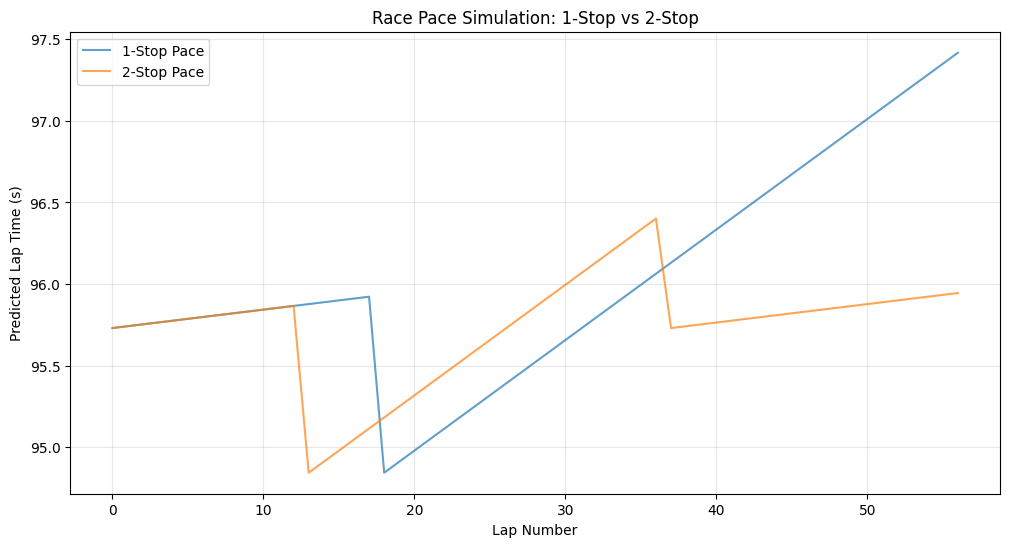

In [8]:
# --- STEP 6: COMPARE RESULTS ---
diff = time_a - time_b
if diff > 0:
    print(f"\n🏆 WINNER: 2-Stop Strategy is faster by {diff:.2f} seconds!")
else:
    print(f"\n🏆 WINNER: 1-Stop Strategy is faster by {abs(diff):.2f} seconds!")

# --- STEP 7: VISUALIZE THE RACE ---
plt.figure(figsize=(12, 6))
plt.plot(laps_a, label="1-Stop Pace", alpha=0.7)
plt.plot(laps_b, label="2-Stop Pace", alpha=0.7)
plt.title("Race Pace Simulation: 1-Stop vs 2-Stop")
plt.xlabel("Lap Number")
plt.ylabel("Predicted Lap Time (s)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()